In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
    
import sys
p = '/home/qnicolas/stationaryWave/'
if p not in sys.path:
    sys.path.append(p)
from mydedalustools import *    

%load_ext autoreload
%autoreload 2

SNAPSHOTS_DIR = "/net/helium/atmosdyn/qnicolas/stationarywave_snapshots/"

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
[1750778638.084127] [iacdipl-6:41874:0]           ib_md.c:282  UCX  ERROR ibv_reg_mr(address=0x7f8539000000, length=39845888, access=0xf) failed: Cannot allocate memory : Please set max locked memory (ulimit -l) to 'unlimited' (current: 8192 kbytes)
[1750778638.084177] [iacdipl-6:41874:0]           mpool.c:269  UCX  ERROR Failed to allocate memory pool (name=rc_recv_desc) chunk: Input/output error
[1750778638.088891] [iacdipl-6:41874:0]         ib_mlx5.c:127  UCX  ERROR mlx5_bond_0: mlx5dv_create_cq(cqe=4096) failed: Cannot allocate memory : Please set max locked memory (ulimit -l) to 'unlimited' (current: 8192 kbytes)
[1750778638.089121] [iacdipl-6:41874:0]      ucp_worker.c:1413 UCX  ERROR uct_iface_open(ud_mlx5/mlx5_bond_0:1) failed: Input/output error


[iacdipl-6:41874] pml_ucx.c:313  Error: Failed to create UCP worker


This notebook presents two tests of a 2-level sigma model: A stationary orographic Rossby wave in midlatitudes, and a Gill pattern in the tropics.
Note that the model has strong damping in the lower layer, which affects the Gill pattern quite strongly.

# Topographic Rossby wave

In [2]:
snapshot_id = 'stationarywave_2level_T32_topo'
zonaljet = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
zonaljet = concat_levels(zonaljet ,2)


## Basic-state wind and geopotential, topography

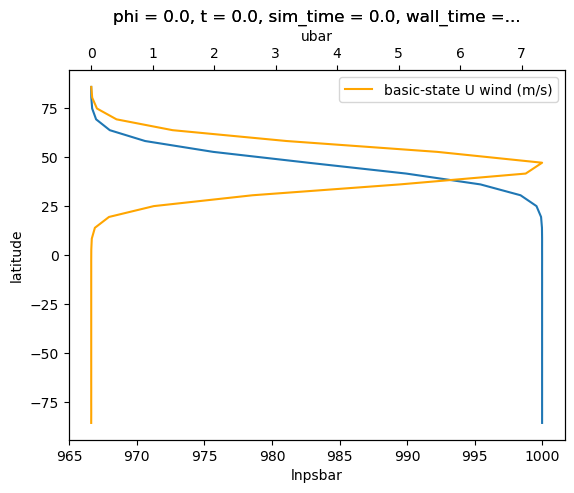

In [3]:
(1e3*np.exp(zonaljet.lnpsbar[0,0])).plot(y='latitude',label='basic-state surface pressure (hPa)')
plt.twiny()
(zonaljet.ubar[0,0,0,:,0]).plot(y='latitude',color='orange',label='basic-state U wind (m/s)')
plt.legend()

Text(0.5, 1.0, 'Topography (m)')

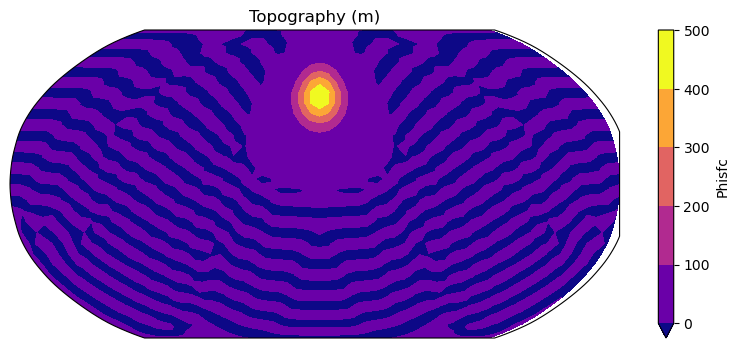

In [4]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(zonaljet.Phisfc[0]/9.81).transpose().plot.contourf(ax=ax,levels=np.arange(0,501,100.),transform=ccrs.PlateCarree(),cmap=plt.cm.plasma)
plt.title('Topography (m)')

## vorticity

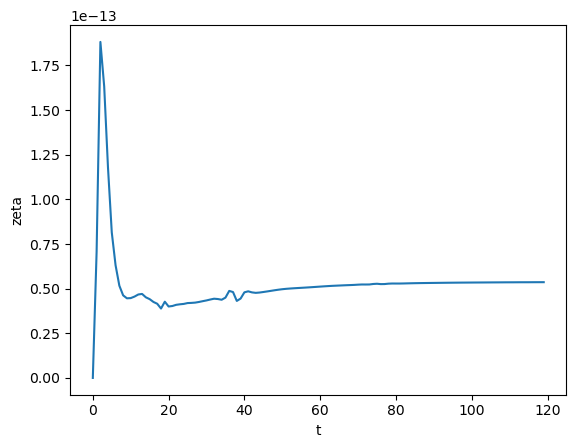

In [5]:
(zonaljet.zeta**2).mean(('longitude','latitude','sigma')).plot()


In [6]:
zonaljet_mean = zonaljet.sel(t=slice(100,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

def plot_topo(ax):
    topo = (zonaljet.Phisfc[0]/9.81).transpose()
    topo.plot.contour(ax=ax,levels=[200.],colors='k',transform=ccrs.PlateCarree())

Text(0.5, 1.0, 'Relative vorticity in upper layer (shading) and Topography')

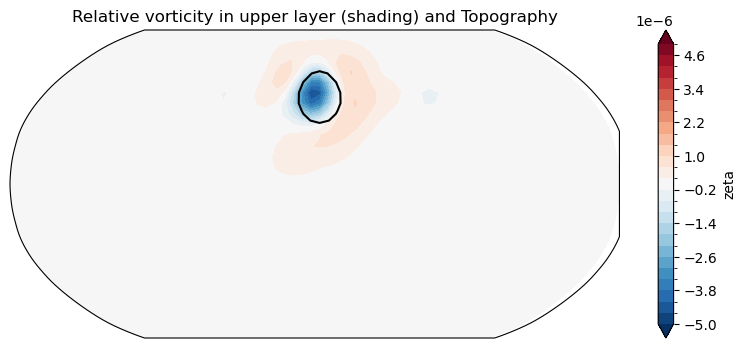

In [7]:
# Perturbation vorticity
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
zonaljet_mean.zeta.isel(sigma=0).plot.contourf(ax=ax,levels=np.arange(-5e-6, 5.1e-6,4e-7),extend='both',transform=ccrs.PlateCarree())
plot_topo(ax)
plt.title('Relative vorticity in upper layer (shading) and Topography')

Text(0.5, 1.0, 'Perturbation surface pressure and perturbation upper-layer wind ')

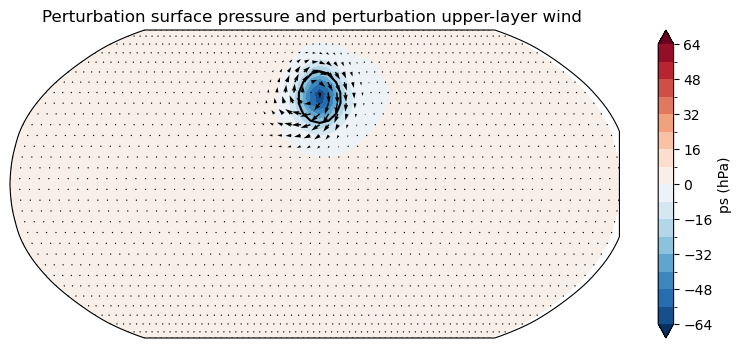

In [8]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(1e3*zonaljet_mean.lnps).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'ps (hPa)'})

plot_topo(ax)

u= (zonaljet_mean.u[0].isel(sigma=0))
v=-(zonaljet_mean.u[1].isel(sigma=0))
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=1; m=n
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k", scale = 100,transform=ccrs.PlateCarree())

plt.title('Perturbation surface pressure and perturbation upper-layer wind ')

# Gill pattern

In [10]:
snapshot_id = 'stationarywave_2level_T32_idealgill'
gill = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
gill = concat_levels(gill ,2)


## Heating pattern

Text(0.5, 1.0, 'Heating in upper layer (K/day)')

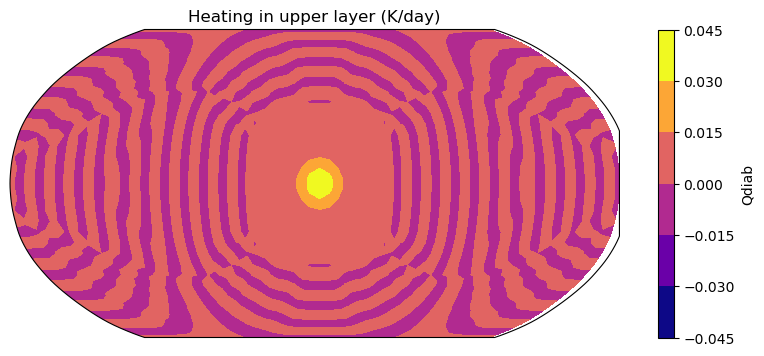

In [12]:
# Perturbation vorticity in rhs run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill.Qdiab.isel(t=0,sigma=0)).transpose().plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cmap=plt.cm.plasma)
plt.title('Heating in upper layer (K/day)')

## Response

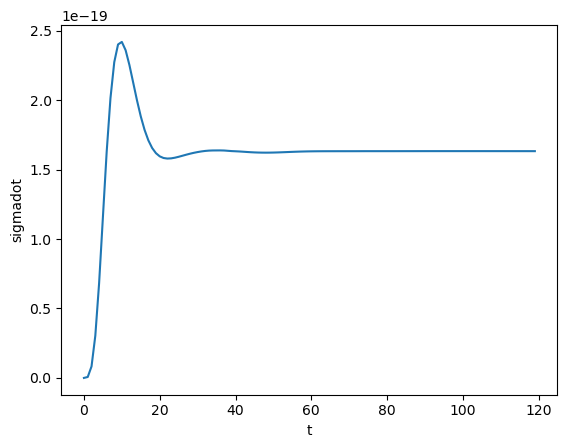

In [13]:
# CONVERGENCE
(gill.sigmadot**2).mean(('longitude','latitude','sigma_stag')).plot()


In [ ]:
gill_mean = gill.sel(t=slice(100,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')
def plot_heating(ax):
    (gill.Qdiab.isel(t=0,sigma=0)).plot.contour(ax=ax,levels=[0.02],colors='k',transform=ccrs.PlateCarree())
gill_mean['omega'] = calc_omega(gill_mean)

Text(0.5, 1.0, 'Perturbation vorticity in upper layer (s^-1)')

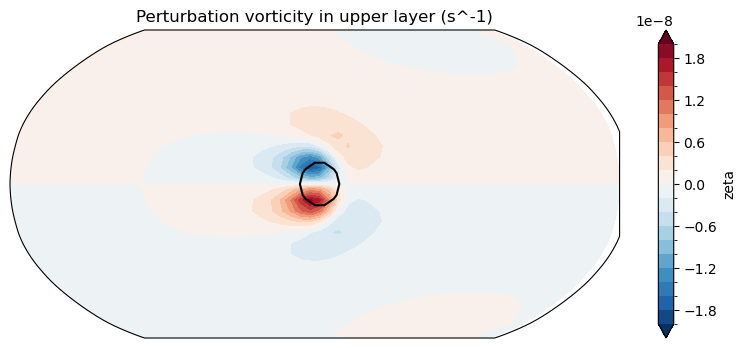

In [16]:
# Perturbation vorticity
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill_mean.zeta.isel(sigma=0)).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
plot_heating(ax)
plt.title('Perturbation vorticity in upper layer (s^-1)')

Text(0.5, 1.0, 'Perturbation surface pressure and lower-layer wind ')

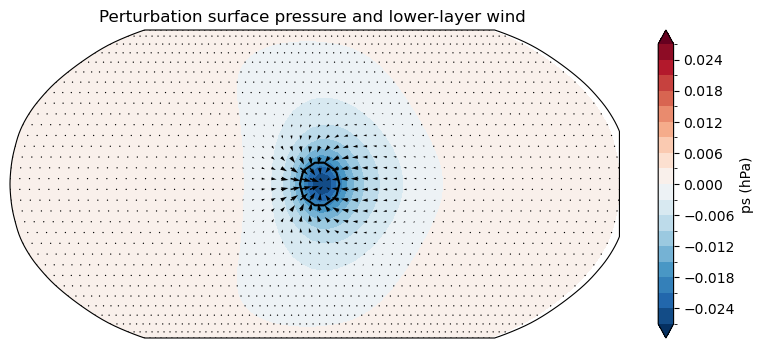

In [31]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(1e3*gill_mean.lnps).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'ps (hPa)'})

plot_heating(ax)

u= (gill_mean.u[0].isel(sigma=1))
v=-(gill_mean.u[1].isel(sigma=1))
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=0.4,transform=ccrs.PlateCarree())

plt.title('Perturbation surface pressure and lower-layer wind ')

Text(0.5, 1.0, 'Perturbation pressure velocity (not sigma_dot) and upper-layer wind ')

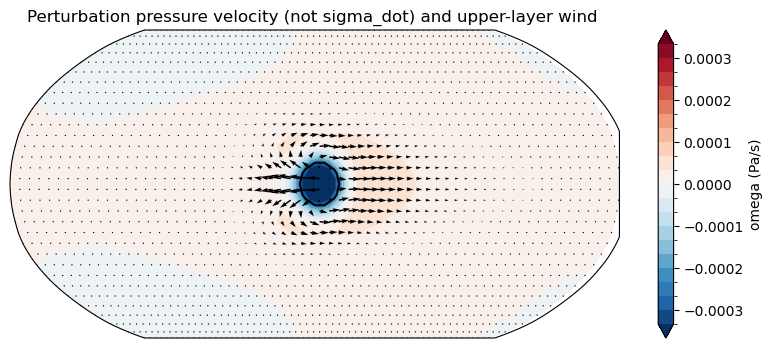

In [32]:
# Perturbation pressure (~p0 * lnps)
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})

(gill_mean.omega.isel(sigma_stag=0)).plot.contourf(ax=ax,levels=np.linspace(-1,1,21)/3e3,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'omega (Pa/s)'})

plot_heating(ax)

u= (gill_mean.u[0].isel(sigma=0))
v=-(gill_mean.u[1].isel(sigma=0))
n=1;m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=0.4,transform=ccrs.PlateCarree())

plt.title('Perturbation pressure velocity (not sigma_dot) and upper-layer wind ')